**<span style="font-family:KerkisSans; font-size:2.5em;">Prediction of the number of COVID-19 deaths in Germany</span>**

<span style="font-family:KerkisSans; font-size:1.5em; color: black">Anna Androvitsanea</span>

<span style="font-family:KerkisSans; font-size:1.5em; color: black">aandrovitsanea@aueb.gr</span>

* In this notebook I predict the number of deaths in Germany, using the data of existing deaths.
  * I download the data [here](https://www.kaggle.com/headsortails/covid19-tracking-germany). 

In [1]:
# Import basic libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg 
from statsmodels.tsa.statespace import sarimax
import statsmodels.formula.api as smf
import statsmodels.api as sm
import warnings
import itertools

warnings.filterwarnings("ignore")

# Exploratory Data Analysis

## Import data

In [2]:
covid_de = pd.read_csv("covid_de.csv", decimal = ".", index_col=False) # load data
covid_de['date'] = pd.to_datetime(covid_de['date']) # transform column date to type datetime
covid_de.set_index('date', inplace=True) # set column data as index

## Check input

In [3]:
print('The dataset has %d entries' %  len(covid_de))
print('It has the following attributes:\n', covid_de.columns)

The dataset has 681124 entries
It has the following attributes:
 Index(['state', 'county', 'age_group', 'gender', 'cases', 'deaths',
       'recovered'],
      dtype='object')


In [4]:
print(covid_de.tail(5)) # take a glimpse at the data

                 state     county age_group gender  cases  deaths  recovered
date                                                                        
2021-02-24  Thueringen  SK Weimar     80-99      M      1       0          1
2021-03-03  Thueringen  SK Weimar     80-99      M      1       0          1
2021-03-13  Thueringen  SK Weimar     80-99      M      1       0          1
2021-03-15  Thueringen  SK Weimar     80-99      M      1       0          1
2021-03-31  Thueringen  SK Weimar     80-99      M      1       0          0


## Resample

In [5]:
# we have deaths per date per county and state
# we must group them according to the date

covid_de_deaths = covid_de.groupby('date')['deaths'].sum() # deaths per day
covid_de_cases = covid_de.groupby('date')['cases'].sum() # cases per day
covid_de_recovered = covid_de.groupby('date')['recovered'].sum() # recovered per day

In [6]:
# computing a 7 day rolling average

covid_de_deaths_rol_ave = covid_de_deaths.rolling(7).mean()

## Plot

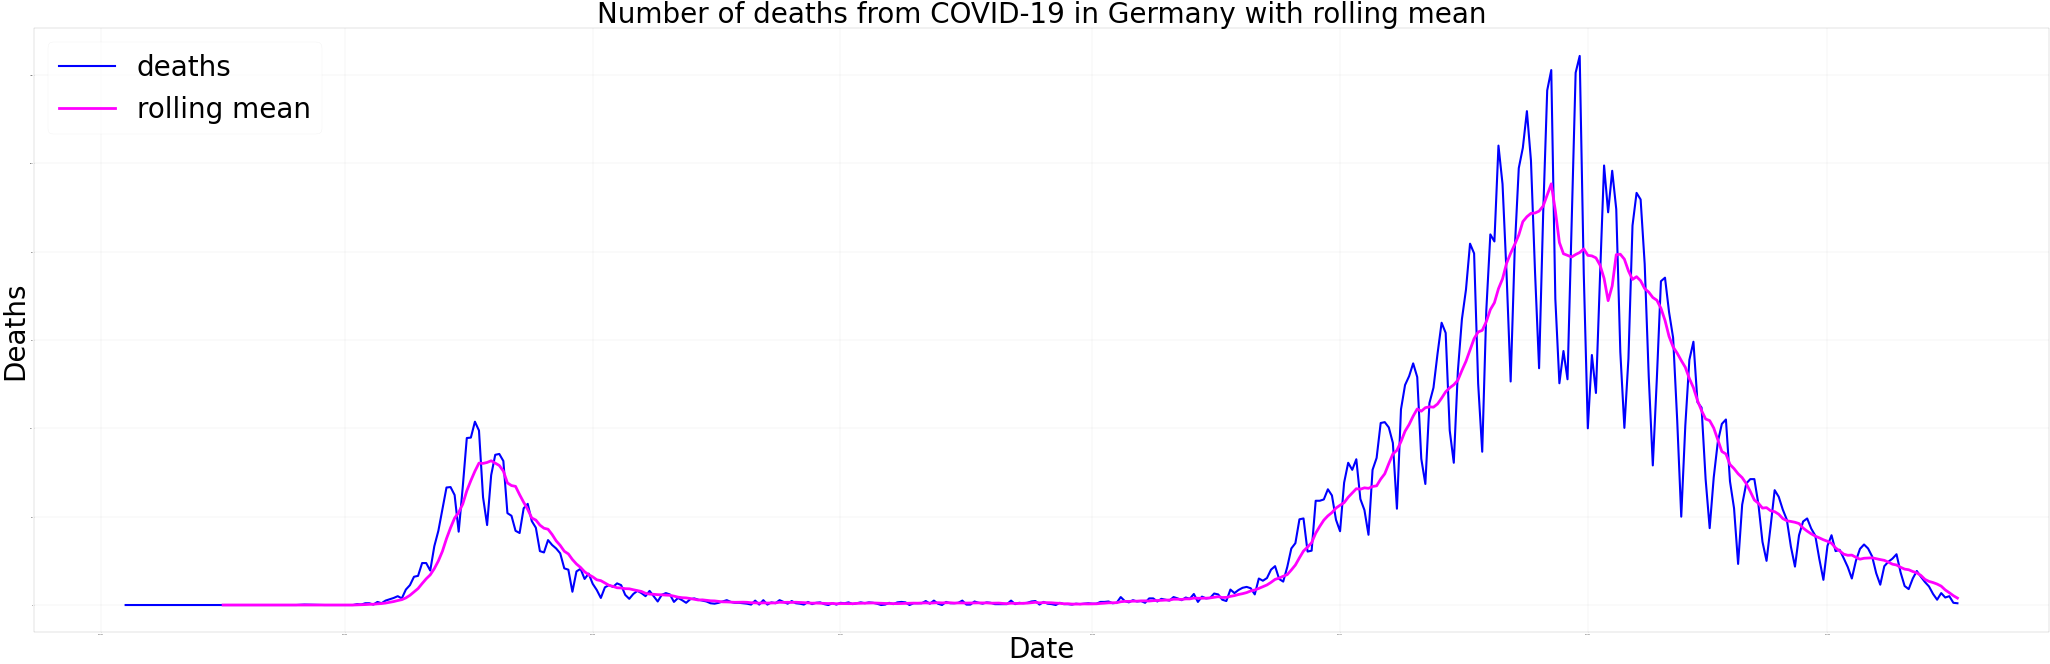

In [7]:
# plot the number of deaths from COVID-19 in Germany with rolling mean

fig, ax = plt.subplots(figsize=(260, 80), dpi=10, 
                facecolor='w', edgecolor='k')


plt.rc('xtick', labelsize=200) 
plt.rc('ytick', labelsize=200) 

plt.title('Number of deaths from COVID-19 in Germany with rolling mean', 
          fontsize=200) # add a title
plt.xlabel('Date', fontsize=200) # add x label
plt.ylabel('Deaths', fontsize=200) # add y label

plt.grid(True)

plt.rc('grid', linestyle="-", color='black', alpha = 1)

plt.rc('xtick', labelsize=200) 
plt.rc('ytick', labelsize=200)
plt.plot(covid_de_deaths, 
         linewidth = 15, 
         c = 'blue',
         label='deaths')
plt.plot(covid_de_deaths_rol_ave, 
         linewidth = 20, 
         c = 'magenta',
         label='rolling mean')
plt.savefig('actual_deaths.png')
plt.legend(fontsize = 200, loc = 'upper left')

In [8]:
starting_date = input('When does your reference period begin? (ie. 2021-02-01): ')

When does your reference period begin? (ie. 2021-02-01): 2021-02-01


In [9]:
# create date parameters 

date_begin_window = np.datetime64(starting_date) # begin of 1st dataset to take into account
# the rolling window we will use has a duration of 15 day
date_end_window = date_begin_window + 14 # end of the 1st dataset to take into account

date_predict_start = date_begin_window + 22 # 1st day to predict deaths
date_predict_end = date_predict_start + 29

In [10]:
print('The day for which I will make a prediction lies',date_predict_start - date_end_window, 'after the last day of the reference dataset')

The day for which I will make a prediction lies 8 days after the last day of the reference dataset


In [11]:
print('I will run for', (date_predict_end - (date_end_window + 8) + 1) ,'my forecasting models in order to predict the deaths on the 8th day after the end of its time window')

I will run for 30 days my forecasting models in order to predict the deaths on the 8th day after the end of its time window


# Models SARIMAX, exponential smoothing and autoregression

## Train/Test

In [12]:
# Run the models SARIMAX, exponential smoothing and autoregression

sa_forecasts = [] # store predictions for each day - sarimax
ar_forecasts = [] # store predictions for each day - auto regression
es_forecasts = [] # store predictions for each day - exponential smoothing
index_forecasts = [] # store the day of prediction.
upper_ci_sarimax = [] # store the upper confidence interval for sarimax
lower_ci_sarimax = [] # store the lower confidence interval for sarimax

date_begin_window = np.datetime64(starting_date) # begin of 1st dataset to take into account

for day in range(30): # iterate for 30 days
    # check if there are nan values and fill them with the mean value
    covid_de_deaths[date_begin_window:(date_begin_window + 14)].fillna(covid_de_deaths[date_begin_window:(date_begin_window + 14)].mean(), inplace=True)
    sa = sarimax.SARIMAX(covid_de_deaths[date_begin_window:(date_begin_window + 14)]).fit() # run the sarimax model
    ar = AutoReg(covid_de_deaths[date_begin_window:(date_begin_window + 14)], 4, old_names=False).fit() # run the auto regression model
    es = sm.tsa.ExponentialSmoothing(covid_de_deaths[date_begin_window:(date_begin_window + 14)]).fit() # run the Exponential smoothing model
    
    upper_ci = sa.get_forecast(8).summary_frame().iloc[7,3] # take mean ci upper
    lower_ci = sa.get_forecast(8).summary_frame().iloc[7,2] # take lower ci upper
    
    upper_ci_sarimax.append(upper_ci) # append the mean ci upper
    lower_ci_sarimax.append(lower_ci) # append the mean ci lower
    
    index_forecasts.append((date_begin_window + 14) + 8) # append the day of forecast
    
    # append the predictions of the 8th day after the end of modelled time frame
    sa_forecasts.append(sa.forecast(8)[-1]) # for the sarimax model
    ar_forecasts.append(ar.forecast(8)[-1]) # run the auto regression model
    es_forecasts.append(es.forecast(8)[-1]) # run the exponential smoothing model
    
    date_begin_window +=  1 # add one day to the beginning

## Forecasts

In [13]:
# Construct a dataframe with the forecasts from start to end of forecasting period

forecasting = pd.DataFrame({'Exp_Smoothing':es_forecasts, 
                            'AutoRegression': ar_forecasts, 
                            'SARIMAX':sa_forecasts,
                            'date':index_forecasts}, index = index_forecasts)
print("Forecasts from start to end of forecasting period")
print(forecasting.head(3), '\n',forecasting.tail(3))

Forecasts from start to end of forecasting period
            Exp_Smoothing  AutoRegression     SARIMAX       date
2021-02-23     177.999999      238.172907  120.594177 2021-02-23
2021-02-24     259.588055      248.421007  197.418643 2021-02-24
2021-02-25     245.000000      212.025552  190.607044 2021-02-25 
             Exp_Smoothing  AutoRegression    SARIMAX       date
2021-03-22      46.000000       48.652123  26.693839 2021-03-22
2021-03-23      87.999999      143.355660  69.944391 2021-03-23
2021-03-24      98.000000      135.052360  82.322205 2021-03-24


## Plot

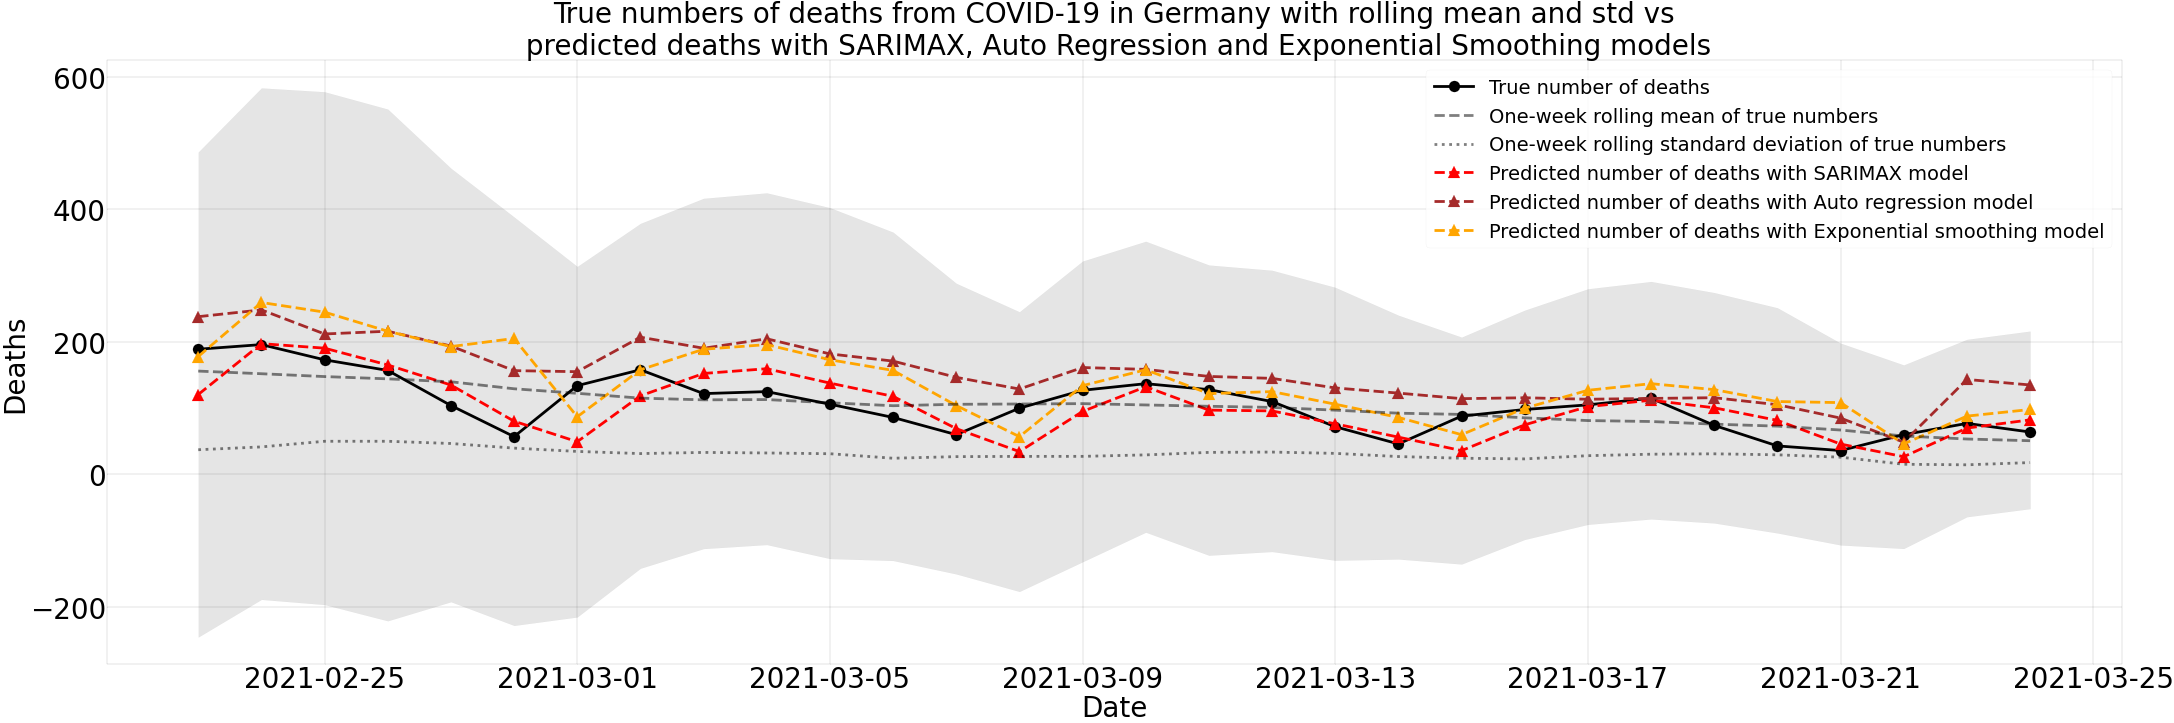

In [14]:
# Plot the true number of deaths and the predicted deaths' number per model
# along with the rolling mean and standard deviation of true numbers

fig, ax = plt.subplots(figsize=(260, 80), dpi=10, 
                facecolor='w', edgecolor='k')


plt.rc('xtick', labelsize=200) 
plt.rc('ytick', labelsize=200) 


plt.title('True numbers of deaths from COVID-19 in Germany with rolling mean and std vs\n predicted deaths with SARIMAX, Auto Regression and Exponential Smoothing models', 
          fontsize=200) # add a title
plt.xlabel('Date', fontsize=200) # add x label
plt.ylabel('Deaths', fontsize=200) # add y label

plt.grid(True)

plt.rc('grid', linestyle="-", color='black', alpha = 1)

deaths, = plt.plot(covid_de_deaths[str(date_predict_start):str(date_predict_end)],
                   label = 'True number of deaths', linewidth=20, color='black', marker='o', markersize = 80)
pred_sarimax, = plt.plot(forecasting.SARIMAX,label = 'Predicted number of deaths with SARIMAX model', 
                         linewidth=20, color='red', linestyle =  'dashed',
                         marker='^', markersize = 80)
pred_autoreg, = plt.plot(forecasting.AutoRegression,label = 'Predicted number of deaths with Auto regression model', 
                         linewidth=20, color='brown', linestyle =  'dashed',
                         marker='^', markersize = 80)
pred_Exp_Smoothing, = plt.plot(forecasting.Exp_Smoothing,label = 'Predicted number of deaths with Exponential smoothing model', 
                         linewidth=20, color='orange', linestyle =  'dashed',
                         marker='^', markersize = 80)
str(date_predict_start - 3)
rolling_mean, = plt.plot(covid_de_deaths[str(date_predict_start - 3):str(date_predict_end+3)].rolling(7, center=True).mean(), 
                         label = 'One-week rolling mean of true numbers', 
                         linewidth=20, color='black', linestyle =  'dashed', alpha = 0.5)
rolling_std, = plt.plot(covid_de_deaths[str(date_predict_start - 3):str(date_predict_end+3)].rolling(7, center=True).std(), 
                         label = 'One-week rolling standard deviation of true numbers', 
                         linewidth=20, color='black', linestyle =  ':', alpha = 0.5)

ax.fill_between(forecasting.SARIMAX.index, lower_ci_sarimax, upper_ci_sarimax, color='k', alpha=0.1)

plt.legend(handles=[deaths, rolling_mean, rolling_std, pred_sarimax, pred_autoreg, pred_Exp_Smoothing], fontsize = 140)
plt.savefig('all_predictions_deaths.png')


---
The **SARIMAX** model appers to have the best fit, followed very close by the **Exponential Smoothing** model.

The **Auto Regression** model appers to be the lest efficient model in this case.

The **rolling mean** curve appers to habe an even better fit on the real deaths, since it is the 7-days average.

---

In [15]:
# Run an OLS Regression for each predicted number against the true number of deaths

# add one column with the true number to the forecasting data frame
forecasting['true_deaths'] = covid_de_deaths[str(date_predict_start):str(date_predict_end)]

model_sar = smf.ols(formula = 'true_deaths ~ SARIMAX' , data=forecasting).fit().summary() # fit model for sarimax
model_autoreg = smf.ols(formula = 'true_deaths ~ AutoRegression', data=forecasting).fit().summary() # fit model for auto reg
model_exp_smooth = smf.ols(formula = 'true_deaths ~ Exp_Smoothing', data=forecasting).fit().summary() # fit model for exp smooth

In [16]:
# Store the results of the ols regression to a dataframe

def reform_df(dft):
    # quick and dirty stacking of cols 2,3 on 0,1
    dfl = dft[[0,1]]
    dfr = dft[[2,3]]
    dfr.columns = 0,1
    dfout = pd.concat([dfl,dfr])
    dfout.columns=['Parameter','Value']
    return dfout

def model_summary_to_dataframe(model):
    # first the middle table      
    results_df = pd.DataFrame(model.summary().tables[1])
    results_df = results_df.set_index(0)
    results_df.columns = results_df.iloc[0]
    results_df = results_df.iloc[1:]
    results_df.index.name='Parameter'

In [17]:
# results of ols for sarimax
metrics_top_sar = reform_df(pd.DataFrame(model_sar.tables[0]))
metrics_bot_sar = reform_df(pd.DataFrame(model_sar.tables[2]))
metrics_df_sar = pd.concat([metrics_top_sar,metrics_bot_sar], axis = 0)
metrics_df_sar.rename(columns={"Value": "SARIMAX"}, inplace = True)

In [18]:
# results of ols for auto regression
metrics_top_autoreg = reform_df(pd.DataFrame(model_autoreg.tables[0]))
metrics_bot_autoreg = reform_df(pd.DataFrame(model_autoreg.tables[2]))
metrics_df_autoreg = pd.concat([metrics_top_autoreg,metrics_bot_autoreg], axis = 0)
metrics_df_autoreg.rename(columns={"Value": "AutoRegression"}, inplace = True)

In [19]:
# results of ols for exponential smoothing
metrics_top_exp_smooth = reform_df(pd.DataFrame(model_exp_smooth.tables[0]))
metrics_bot_exp_smooth = reform_df(pd.DataFrame(model_exp_smooth.tables[2]))
metrics_df_exp_smooth = pd.concat([metrics_top_exp_smooth,metrics_bot_exp_smooth], axis = 0)
metrics_df_exp_smooth.rename(columns={"Value": "Exp_Smoothing"}, inplace = True)

In [20]:
# Make a datagrame with the three ols results

metrics = pd.concat([metrics_df_sar,metrics_df_autoreg['AutoRegression'],metrics_df_exp_smooth['Exp_Smoothing']], axis = 1)
metrics.drop([7,8], axis=0, inplace = True)
print('These are the metrics to compare the three models:\n', metrics)

These are the metrics to compare the three models:
                Parameter           SARIMAX    AutoRegression     Exp_Smoothing
0         Dep. Variable:       true_deaths       true_deaths       true_deaths
1                 Model:               OLS               OLS               OLS
2                Method:     Least Squares     Least Squares     Least Squares
3                  Date:  Sun, 04 Apr 2021  Sun, 04 Apr 2021  Sun, 04 Apr 2021
4                  Time:          16:43:30          16:43:30          16:43:30
5      No. Observations:                30                30                30
6          Df Residuals:                28                28                28
0    R-squared:                      0.502             0.635             0.401
1    Adj. R-squared:                 0.484             0.622             0.380
2    F-statistic:                    28.18             48.68             18.78
3    Prob (F-statistic):          1.19e-05          1.38e-07          0.000171


---

Since, we have seen that SARIMAX is a good fit for this model, we will work with that.

---

# SARIMAX

---

The SARIMAX model has been used with the default values up to now.
I will seek accuracy on defining the parameters.
Hint: The implementation is influced from this [post](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b) which I found during a short internet search.

The aim is to minimize the AIC or BIC factors. Source: [Wikipedia](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)

---

## Fine-tuning

In [21]:
# Define the a,b,c parameters of SARIMAX

a = b = c = range(0, 3)
sar_param = list(itertools.product(a, b, c))

parameters = []
AIC_s = []
BIC_s = []
for param_set in sar_param:
    sarimax_mod = sarimax.SARIMAX(covid_de_deaths, # run for all our data
                                 order = param_set)
    fit = sarimax_mod.fit()
    parameters.append(param_set)
    AIC_s.append(fit.aic)
    BIC_s.append(fit.bic)
    print('SARIMAX{} - AIC:{} - BIC:{}'.format(param_set, fit.aic, fit.bic))
    

SARIMAX(0, 0, 0) - AIC:6051.979256184375 - BIC:6056.019510895652
SARIMAX(0, 0, 1) - AIC:5572.294076341732 - BIC:5580.374585764287
SARIMAX(0, 0, 2) - AIC:5412.744136472607 - BIC:5424.86490060644
SARIMAX(0, 1, 0) - AIC:4950.620226007641 - BIC:4954.658096927563
SARIMAX(0, 1, 1) - AIC:4890.979663075681 - BIC:4899.055404915525
SARIMAX(0, 1, 2) - AIC:4818.871396670727 - BIC:4830.985009430494
SARIMAX(0, 2, 0) - AIC:5108.168340373871 - BIC:5112.203821806395
SARIMAX(0, 2, 1) - AIC:4947.8415009785 - BIC:4955.91246384355
SARIMAX(0, 2, 2) - AIC:4887.572923271764 - BIC:4899.679367569338
SARIMAX(1, 0, 0) - AIC:4958.117035250896 - BIC:4966.197544673451
SARIMAX(1, 0, 1) - AIC:4891.752727817464 - BIC:4903.873491951296
SARIMAX(1, 0, 2) - AIC:4833.119008458818 - BIC:4849.280027303927
SARIMAX(1, 1, 0) - AIC:4925.191221620361 - BIC:4933.266963460205
SARIMAX(1, 1, 1) - AIC:4883.508259888693 - BIC:4895.621872648459
SARIMAX(1, 1, 2) - AIC:4802.976565804303 - BIC:4819.128049483992
SARIMAX(1, 2, 0) - AIC:5105.4

In [22]:
# Group data to two series and one dataframe
aicss = pd.Series(AIC_s, index = parameters, name='AIC')
bicss = pd.Series(BIC_s, index = parameters, name='BIC')
params_results = pd.concat([aicss, bicss], axis = 1)

# The objective is to minimize the AIC, or BIC values for a good model.

print('The minimum ACI is :', aicss.min())
print('This is for the set :\n', params_results[params_results.AIC == aicss.min()])
print('The minimum BIC is :', bicss.min())
print('This is for the set :\n', params_results[params_results.BIC == bicss.min()])

The minimum ACI is : 4629.24572445613
This is for the set :
                    AIC          BIC
(2, 1, 2)  4629.245724  4649.435079
The minimum BIC is : 4649.435079055741
This is for the set :
                    AIC          BIC
(2, 1, 2)  4629.245724  4649.435079


In [23]:
print('Therefore, I work with the set that minimizes the AIC and BIC :\n', params_results[params_results.BIC == bicss.min()] )

Therefore, I work with the set that minimizes the AIC and BIC :
                    AIC          BIC
(2, 1, 2)  4629.245724  4649.435079


## Forecasts

In [24]:
# Run the models SARIMAX, exponential smoothing and autoregression

sa_forecasts_up = [] # store predictions for each day - sarimax
index_forecasts_up = [] # store the day of prediction.
upper_ci_sarimax_up = [] # store the upper confidence interval for sarimax
lower_ci_sarimax_up = [] # store the lower confidence interval for sarimax

date_begin_window = np.datetime64(starting_date) # begin of 1st dataset to take into account

for day in range(30): # iterate for 30 days
    # check if there are nan values and fill them with the mean value
    covid_de_deaths[date_begin_window:(date_begin_window + 14)].fillna(covid_de_deaths[date_begin_window:(date_begin_window + 14)].mean(), inplace=True)
    sa = sarimax.SARIMAX(covid_de_deaths[date_begin_window:(date_begin_window + 14)],
                        order = params_results[params_results.BIC == bicss.min()].index[0]).fit() # run the sarimax model
    
    upper_ci = sa.get_forecast(8).summary_frame().iloc[7,3] # take mean ci upper
    lower_ci = sa.get_forecast(8).summary_frame().iloc[7,2] # take lower ci upper
    
    upper_ci_sarimax_up.append(upper_ci) # append the mean ci upper
    lower_ci_sarimax_up.append(lower_ci) # append the mean ci lower
    
    index_forecasts_up.append((date_begin_window + 14) + 8) # append the day of forecast
    
    # append the predictions of the 8th day after the end of modelled time frame
    sa_forecasts_up.append(sa.forecast(8)[-1]) # for the sarimax model
    
    date_begin_window +=  1 # add one day to the beginning

In [25]:
# Construct a dataframe with the forecasts from start to end of forecasting period

forecasting_sarimax = pd.DataFrame({'SARIMAX':sa_forecasts_up,
                            'date':index_forecasts_up}, index = index_forecasts_up)

In [26]:
print("Predictions\n")
print("Date, Actual deaths, Predicted (SARIMAX), Predicted (Rolling mean)")
print("Date       , Death, Pr. SAR., Pr. Roll.")
print('---------------------------------------')
for day in range(len(forecasting_sarimax.index)):

    idx = str(forecasting_sarimax.index[day].date())
    print(idx, ' - ',covid_de_deaths[idx],' - ', 
          int(forecasting_sarimax.SARIMAX[idx]),' - ',
          int(covid_de_deaths[str(date_predict_start-3):str(date_predict_end+3)].rolling(7, center=True).mean()[idx]))
    print('----------------------------------')

Predictions

Date, Actual deaths, Predicted (SARIMAX), Predicted (Rolling mean)
Date       , Death, Pr. SAR., Pr. Roll.
---------------------------------------
2021-02-23  -  189  -  254  -  156
----------------------------------
2021-02-24  -  196  -  306  -  152
----------------------------------
2021-02-25  -  173  -  213  -  147
----------------------------------
2021-02-26  -  157  -  223  -  144
----------------------------------
2021-02-27  -  104  -  214  -  139
----------------------------------
2021-02-28  -  57  -  210  -  129
----------------------------------
2021-03-01  -  134  -  167  -  122
----------------------------------
2021-03-02  -  158  -  219  -  115
----------------------------------
2021-03-03  -  122  -  154  -  112
----------------------------------
2021-03-04  -  125  -  194  -  113
----------------------------------
2021-03-05  -  106  -  126  -  108
----------------------------------
2021-03-06  -  86  -  181  -  103
----------------------------------
20

## Plot

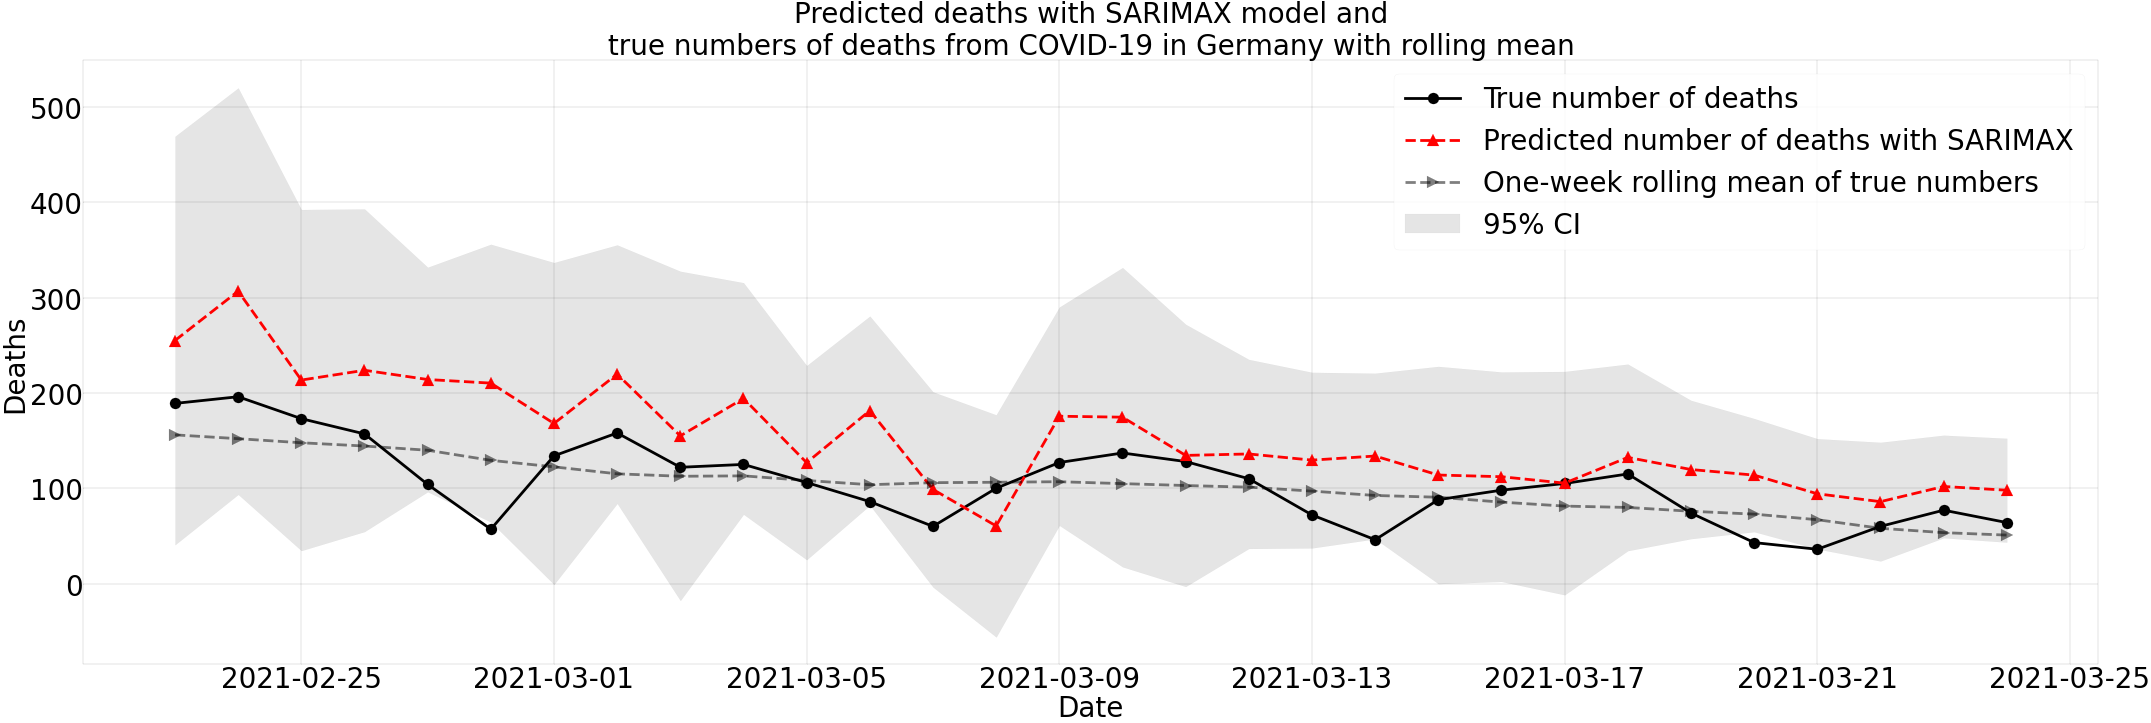

In [27]:
# Plot the true number of deaths and the predicted deaths' number for SARIMAX
# along with the rolling mean of true numbers

fig, ax = plt.subplots(figsize=(260, 80), dpi=10, 
                facecolor='w', edgecolor='k')


plt.rc('xtick', labelsize=200) 
plt.rc('ytick', labelsize=200) 


plt.title('Predicted deaths with SARIMAX model and\n true numbers of deaths from COVID-19 in Germany with rolling mean ', 
          fontsize=200) # add a title
plt.xlabel('Date', fontsize=200) # add x label
plt.ylabel('Deaths', fontsize=200) # add y label

plt.grid(True)

plt.rc('grid', linestyle="-", color='black', alpha = 1)

deaths, = plt.plot(covid_de_deaths[str(date_predict_start):str(date_predict_end)],
                   label = 'True number of deaths', linewidth=20, color='black', marker='o', markersize = 80)

pred_sarimax, = plt.plot(forecasting_sarimax['SARIMAX'],label = 'Predicted number of deaths with SARIMAX', 
                         linewidth=20, color='red', linestyle =  'dashed', marker='^', markersize = 80)

rolling_mean, = plt.plot(covid_de_deaths[str(date_predict_start-3):str(date_predict_end+3)].rolling(7, center=True).mean(), 
                         label = 'One-week rolling mean of true numbers', 
                         linewidth=20, color='black', linestyle =  'dashed', alpha = 0.5, marker='>', markersize = 80)


ax.fill_between(forecasting_sarimax.index, lower_ci_sarimax_up, upper_ci_sarimax_up, color='k', alpha=0.1,
               label = '95% CI')

plt.legend(handles=[deaths, rolling_mean, pred_sarimax], fontsize = 200, loc = 'upper left')
ax.legend(fontsize = 200, loc = 'upper right')
plt.savefig('predicted_deaths.png')


<span style="font-family:KerkisSans; font-size:1.7em; color: black">The model provides a good fit.
On total the true numbers stay within the 95% confidence interval.</span>